# Introductory applied machine learning (INFR10069)

# Assignment 2: Linear regression

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and **submit it electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw1 05_Assignment_2.ipynb`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename=05_Assignment_2.ipynb
local_scp_filepath=~/git/iaml2017/${filename}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath} ${UUN}@${server_address}:${filename}
# rsync -rl ${local_scp_filepath} ${UUN}@${server_address}:${filename}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw1 05_Assignment_2.ipynb
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Execute the cell below to import all packages you will be using in the rest of the assignemnt.

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
%matplotlib inline

## Description of the dataset
This assignment is based on the automobile pricing dataset. Our goal will be to predict the price of automobiles based on various attributes. This data set consists of three types of entities: 

1. The specification of an automobile in terms of various characteristics 

1. Assigned insurance risk rating 
   * this rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuaries call this process ”symboling”. A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe. 

1. Normalized losses in use as compared to other cars
  * the third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year (avg_loss/car/year). 


To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We removed any instances that had one or more missing values and randomized the data set. The resulting representation is much more compact and can be used directly to perform our experiments.


## 1. Simple Linear Regression [50%]
We will begin by studying a simple Linear Regression model. Such a model will consider the relationship between a dependent (response) variable and only one independent (explanatory) variable. When applying machine learning in practice it can be prudent to start out simple in order to get a feeling for the dataset and for any potential difficulties that might warrant a more sophisticated model. In this Section we will consider one independent variable (i.e. feature) `engine-power` against the dependent variable (i.e. target) `price`.

### ========== Question 1.1 --- [1 mark] ==========
Load the dataset `train_auto_numeric.csv` into a pandas DataFrame called `auto_numeric`. Display the number of data points and attributes in the dataset.

In [7]:
# Read data from csv file
auto_numeric = pd.read_csv('datasets/train_auto_numeric.csv')

### ========== Question 1.2 --- [1 mark] ==========
Display the first 8 instances of the dataset.

In [8]:
# Display the first 8 data points
auto_numeric.head(8)

,normalized-losses,wheel-base,length,width,height,engine-size,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,mean-effective-pressure,torque,price
0,164.0,99.8,176.6,66.2,54.3,8.85,3.19,3.40,10.0,102000.0,5500.0,24.0,30.0,40.52,57.68,13950.0
1,110.0,99.4,162.4,66.4,54.3,15.18,3.19,3.40,8.0,115000.0,5500.0,18.0,22.0,47.39,59.59,17450.0
2,158.0,105.8,192.7,71.4,51.6,15.18,3.94,2.80,8.5,70000.0,4400.0,28.0,30.0,0.85,3344.79,17710.0
3,106.0,86.6,158.7,67.7,55.9,13.74,3.13,3.50,7.8,140000.0,5600.0,32.0,20.0,44.74,68.97,23875.0
4,192.0,101.2,176.8,64.8,54.3,8.67,3.50,2.80,8.8,101000.0,5800.0,23.0,29.0,44.78,53.48,16430.0
5,194.0,110.0,190.9,71.4,58.7,8.67,3.78,3.90,22.5,101000.0,6000.0,47.0,53.0,1.80,1330.28,16925.0
6,188.0,101.2,176.8,64.8,54.3,26.58,3.31,3.19,9.0,121000.0,4250.0,21.0,28.0,7.19,377.06,20970.0
7,150.0,101.2,176.8,64.8,56.1,26.58,3.03,3.19,8.0,134000.0,4400.0,28.0,37.0,57.37,48.20,21105.0


### ========== Question 1.3 --- [1 mark] ==========
Display the summary statistics for the dataset.

In [9]:
# Display summary statistics
auto_numeric.describe()

,normalized-losses,wheel-base,length,width,height,engine-size,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,mean-effective-pressure,torque,price
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,121.955975,98.559748,171.698113,65.729560,53.925157,14.056352,3.294528,3.219874,10.446855,98528.301887,5072.012579,27.113208,32.327044,46.180503,200.055031,11684.723270
std,39.434186,5.803361,12.656791,2.292021,2.410446,17.143568,0.296959,0.381833,4.414796,34123.715967,549.988239,7.848229,8.231998,28.780966,513.289289,6744.910579
min,65.000000,86.600000,141.100000,60.300000,49.400000,3.390000,2.540000,2.070000,7.000000,48000.000000,4150.000000,15.000000,18.000000,0.490000,19.400000,5118.000000
25%,93.000000,94.500000,163.400000,64.000000,52.000000,6.960000,3.050000,3.070000,8.600000,69000.000000,4800.000000,22.000000,26.500000,21.775000,34.140000,7372.000000
50%,110.000000,97.000000,171.700000,65.400000,54.100000,9.030000,3.270000,3.270000,9.000000,92000.000000,5100.000000,26.000000,32.000000,49.800000,55.900000,9233.000000
75%,145.000000,101.200000,177.800000,66.500000,55.600000,14.885000,3.580000,3.410000,9.400000,116000.000000,5450.000000,31.000000,37.000000,68.495000,119.990000,14719.500000
max,256.000000,115.600000,202.600000,71.700000,59.800000,174.160000,3.940000,4.170000,23.000000,200000.000000,6600.000000,49.000000,54.000000,99.850000,3912.870000,42056.000000


### ========== Question 1.4 --- [2 marks] ==========
Produce a scatter plot of `price` against `engine-power`. Label axes appropriately and include a title in your plot.

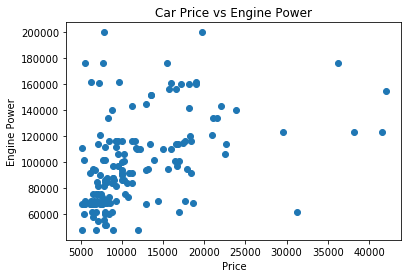

In [12]:
# Display scatter plot of price vs engine power
plt.scatter(x='price',y='engine-power', data=auto_numeric)
# Title and label the plot
plt.title('Car Price vs Engine Power')
plt.xlabel('Price')
plt.ylabel('Engine Power')
plt.show()

### ========== Question 1.5 --- [2 marks] ==========
Do you think that engine-power alone is sufficient for predicting the price? Can you make any other observations on the data from the above plot? Please explain your answer in 2-3 sentences. 

#### Answer
I don't think that engine-power alone is sufficient for predicting the price of a car in this dataset. Although there is possibly a loose linear pattern visible in the data the single variable alone doesn't look effective enough to predict price accurately. Also there are many outliers that will make it difficult for a regression to extract any real pattern.

### ========== Question 1.6 --- [2 marks] ==========
Visualise the distribution of the car prices. Choose a sensible value for the number of bins in the histogram. Again, label axes appropriately and include a title in your plot.

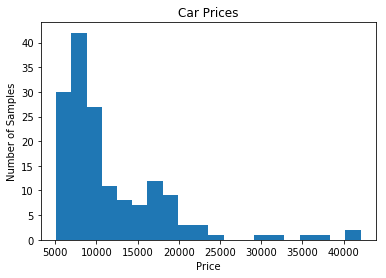

In [13]:
# Build a histogram
plt.hist(x='price', data=auto_numeric, bins=20)
# Set the title and label axes
plt.title('Car Prices')
plt.xlabel('Price')
plt.ylabel('Number of Samples')
plt.show()

### ========== Question 1.7 --- [2 marks] ==========
How could you preprocess the data to improve the performance of linear regression? Don’t do it at this stage, but instead in one sentence explain why you would do what you suggested.

#### Answer
The data appears to be partially exponentially distributed. A way to make it more linear might be to take the log as this would reverse the exponential distribution and make it linear. Although this might make the model more accurate I don't think that it's necessarily a perfect solution. A better solution would be to use more descriptive data (either more variables or better ones).

### ========== Question 1.8 --- [1 mark] ==========
Now we want to build a simple linear regression model. First we need to define our input and target variables. Store the values of the attribute `engine-power` in a vector `X` and the values of our target variable `price` in a vector `y`.

In [17]:
# Set input variable (engine power)
engine_power = np.array(auto_numeric['engine-power'])
# Set target values (price)
price = auto_numeric['price']

### ========== Question 1.9 --- [1 mark] ==========
For technical reasons, we need to convert `X` into a 2D array, otherwise we will receive an error when trying to use it for building models. Perform this transformation and confirm that the shape of the resulting array is (`n`,1) where `n` is the number of instances in the dataset. 

In [20]:
# Convert the engine power variable from an array to a matrix
engine_power_mat = engine_power.reshape(engine_power.size, 1)
# Display the shape of the matrix
print(engine_power_mat.shape)

(159L, 1L)


### ========== Question 1.10 --- [1 mark] ==========
Now we want to use Hold-out validation to split the dataset into training and testing subsets. Use 80% of the data for training and the remaining 20% for testing. Store your data into matrices `X_train`, `X_test`, `y_train`, `y_test`.

In [22]:
# Use the sklearn method to split the dataset
X_train, X_test, y_train, y_test = train_test_split(engine_power_mat, price, test_size=0.2, random_state=1)

### ========== Question 1.11 --- [2 marks] ==========
By using Scikit-learn's [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fit a model to the training data. When initialising the model, set the `normalize` parameter to `True` and use default settings for the other parameters.

In [23]:
# Fit a linear regression to the data
linear_reg = LinearRegression(normalize=True).fit(X_train, y_train)

### ========== Question 1.12 --- [2 marks] ==========
By looking into the attributes of your model, write down an equation for predicting the price of a car given the engine-power.

In [24]:
# Print the coefficient for the regression
print('Coefficient:',linear_reg.coef_[0])
# Print the intercept
print('Intercept:', linear_reg.intercept_)

Coefficient: 0.096982253264
Intercept: 2457.87071154


#### Equation
y = 0.0970x + 2457.87

### ========== Question 1.13 --- [3 marks] ==========
What happens to the price as one more unit of engine-power is added? By examining the magnitude of the regression coefficient is it possible to tell whether or not engine-power is an important influential variable on price? Explain your answer in 1-2 sentences.

#### Answer
The price of a car increases by by 0.09 for every unit of power that is added according to the linear model. It's not possible to tell definitively whether engine-power is an influential variable on the price based on regression coefficient alone. However, in this example the regression coefficient is close to 0, which intuitively indicates that there is no linear correlation between price and engine power or that the scale of the variables is highly dissimilar (which is clearly the case in this example).

### ========== Question 1.14 --- [2 marks] ==========
Produce a scatter plot similar to the one in Question 1.4 but use training data only this time. Add the regression line to the plot and show the predictions on the training set by using a different marker. Label axes appropriately and add a title to the graph. 

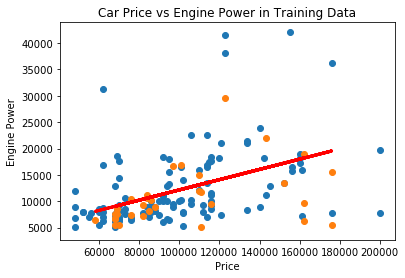

In [25]:
# Plot training data
plt.scatter(x=X_train, y=y_train)
# Plot test data
plt.scatter(x=X_test, y=y_test)
# Draw the linear regression
plt.plot(X_test, linear_reg.predict(X_test), color='red', linewidth=3)
plt.title('Car Price vs Engine Power in Training Data')
plt.xlabel('Price')
plt.ylabel('Engine Power')
plt.show()

### ========== Question 1.15 --- [2 marks] ==========
So far we have used Hold-out validation. Can you think of a disadvantage of using this method, especially when dealing with small datasets?

#### Answer
The disadvantage of Hold-out validation is that it reduces the amount of training data available since some of it needs to be reserved for testing. With a small dataset this can be an issue as all the data available should be used for training in order to increase training accuracy.

### ========== Question 1.16 --- [1 mark] ==========
Now we want to use k-fold cross-validation to evaluate the performance of the regression model. Famliriase yourself with the sklearn method [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) and make sure you understand the differences between Hold-out and K-fold cross-validation. By using Scikit-learn's [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class construct a 5-fold cross-validation object. Set the `shuffle` parameter to `True` and `random_state` to `0`. Use the object to print the training and validation indices for the `auto_numeric` dataset (hint: see the `split` method).

In [27]:
# Create the crossvalidation object
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in kf.split(auto_numeric):
    # Display the folds
    print("Train: ", train_index, "\r\nTest: ", test_index, "\r\n")

Train:  [  0   1   2   3   4   5   6   9  10  11  12  13  14  15  16  17  18  20
  21  22  23  25  27  28  29  30  31  32  34  35  36  38  39  41  42  43
  46  47  48  49  50  51  52  53  55  57  58  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  84  87  88  89  91  92
  93  94  96  97  98  99 100 101 102 103 104 105 106 107 108 109 111 112
 113 114 115 116 117 118 121 122 123 124 125 127 129 130 132 133 135 136
 137 138 139 140 141 143 145 146 147 149 150 151 152 153 154 155 156 157
 158] 
Test:  [  7   8  19  24  26  33  37  40  44  45  54  56  59  60  61  62  63  83
  85  86  90  95 110 119 120 126 128 131 134 142 144 148] 

Train:  [  0   1   3   4   5   6   7   8   9  11  12  13  14  15  17  19  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  37  38  39  40  41  42
  44  45  46  47  48  49  50  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  67  68  69  70  72  75  76  77  78  79  81  82  83  84  85
  86  87  88  90  91  92  94  95  

### ========== Question 1.17 --- [3 marks] ==========
By making use of the iterator you constructed in the previous question, loop through the 5 folds and display the mean value of the `price` variable for the training instances in each fold. 
The University of Edinburgh is a charitable body, registered in
Scotland, with registration number SC005336.

In [28]:
# Make an object to hold mean for each fold
price_average = np.zeros(5)
i = 0
# Iterate over each fold
for train_index, test_index in kf.split(auto_numeric):
    # Set the mean for the current fold
    price_average[i] = np.mean(auto_numeric.loc[train_index]['price'])
    i+=1
print('Mean Price per Fold: ', price_average)

Mean Price per Fold:  [ 11853.26771654  11635.97637795  11689.87401575  11709.82677165
  11535.84375   ]


### ========== Question 1.18 --- [3 marks] ==========
Now initialise a new `LinearRegression` model and fit it by making use of the cross-validation iterator, the `X` and `y` arrays defined above and the [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) function. Display the shape of your prediction and confirm it has the same dimensionality as your `y` vector.

In [30]:
# Copy the dataset
auto_numeric_copy = auto_numeric.copy()
# Set the target and training variables
x_data = auto_numeric_copy.drop('price', axis=1)
y_data = auto_numeric_copy['price']
# Create a linear model
linear_model_crossVal = LinearRegression()
# Fit linear model
linear_model_crossVal.fit(X=x_data, y=y_data)
# Run a prediction using the crossval iterator
y_pred_cross_val = cross_val_predict(linear_model_crossVal,X=np.array(x_data['engine-power']).reshape(-1,1), y=y_data, cv=kf.split(auto_numeric_copy))
# Confirm dimensions match
print('y vector dimension: ', y_data.shape, ' prediction dimension: ', y_pred_cross_val.shape)

y vector dimension:  (159L,)  prediction dimension:  (159L,)


### ========== Question 1.19 --- [2 marks] ==========
Report the Coefficient of Determination (R^2), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and Correlation Coefficient (CC) from the simple linear regression model you build in Question 1.18. *Hint: RMSE is the square root of the Mean Squared Error (MSE). For CC you might find numpy's [`corrcoef`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html) function useful.* 

In [35]:
# Print all of the metrics for the trained data
print('Coefficient of Determination:', r2_score(y_true=y_data, y_pred=y_pred_cross_val))
print('RMSE:', np.sqrt(mean_squared_error(y_true=y_data, y_pred=y_pred_cross_val)))
print('MAE:', mean_absolute_error(y_true=y_data, y_pred=y_pred_cross_val))
print('Correlation Coefficient:',np.corrcoef(x=y_pred_cross_val, y=y_data))

Coefficient of Determination: 0.173005270976
RMSE: 6114.45211862
MAE: 3987.95779619
Correlation Coefficient: [[ 1.         0.4171222]
 [ 0.4171222  1.       ]]


### ========== Question 1.20 --- [4 marks] ==========
What do the above metrics intend to measure? Relate the values of CC, MAE and RMSE to the observations you made in Question 1.5. Explain your answer in 1-2 short paragraphs.

#### Answer
The coefficient of determination indicates how accurate the prediction is. It produces a number between 0 and 1 indicating what proportion of the data is described by the prediction.

Root Mean Squared Error and Mean Absolute Error both measure the avergage deviation of the data from the prediction. The primary difference between these two metrics is that because RMSE squares the errors before taking the mean it ends up weighting larger error values more heavily than MAE. For this problem I would expect there to be some really large outliers (i.e. cars that have small engines but are really expensive for other reasons), in which case MAE might be a more appropriate metric to use to quantify the error.

The correlation Coefficient indicates how strong of a linear relationship there is between the x and y data. In this case a coefficient of 0.42 shows that there isn't a strong correlation between engine-power and price.

### ========== Question 1.21 --- [3 marks] ==========
Show a histogram of the residuals of the linear regression model (i.e. true - predicted values). Label axes appropriately and add a title to your plot. Does the distribution of residuals look like what you expected?

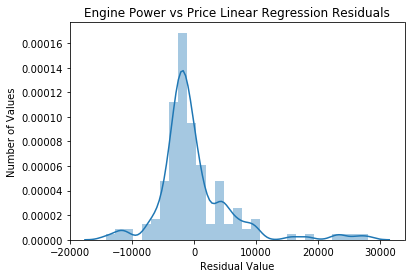

In [32]:
# Calculate the residuals as true-pred
residuals = y_data-y_pred_cross_val
# Plot residuals
sns.distplot(residuals)
# Label residual plot
plt.title('Engine Power vs Price Linear Regression Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Number of Values')
plt.show()

#### Answer
The distribution of residuals looks approximately as I would expect. Although there are a lot of high residual values (indicating that the model is not very predictive), the mode is the bin with the smallest values and the number of points decreases with higher residual values showing that the model is doing alright.

### ========== Question 1.22 --- [2 marks] ==========
Load the new dataset `train_auto_base.csv` into a pandas DataFrame `auto_base`. Again by using the `engine-power` attribute as predictor and `price` as target variable build a LinearRegression model on this dataset. Report the R^2, RMSE, MAE and CC metrics for this model by making use of the K-fold CV iterator constructed in Question 1.16.

In [34]:
# load the auto base dataset
auto_base = pd.read_csv('datasets/train_auto_base.csv')
# Calculate training and target variables
x_data_base = np.array(auto_base['engine-power']).reshape(-1, 1)
y_data_base = auto_base['price']
# Create a linear model
linear_model_base = LinearRegression().fit(X=x_data_base, y=y_data_base)
# Train linear model using the crossval iterator
y_pred_base = cross_val_predict(linear_model_base, X=x_data_base, y=y_data_base, cv=kf.split(auto_base))
# Report Statistics
print('Coefficient of Determination:', r2_score(y_true=y_data_base, y_pred=y_pred_base))
print('RMSE:', np.sqrt(mean_squared_error(y_true=y_data_base, y_pred=y_pred_base)))
print('MAE:', mean_absolute_error(y_true=y_data_base, y_pred=y_pred_base))
print('Correlation Coefficient:',np.corrcoef(x=y_pred_base, y=y_data_base))

Coefficient of Determination: -0.00213595381121
RMSE: 6730.84360395
MAE: 4901.86096203
Correlation Coefficient: [[ 1.         -0.06191442]
 [-0.06191442  1.        ]]


### ========== Question 1.23 --- [2 marks] ==========
Show a scatter plot of predicted vs. true prices and another one of predicted price vs. engine-power. Use a single plot with two subplots. Label axes appropriately.

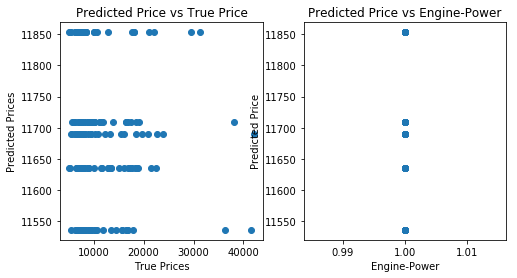

In [37]:
# Setup two subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
# Create scatter plot of predicted vs true
ax1.scatter(x=y_data_base, y=y_pred_base)
# Create scatter plot of predicted price vs engine power
ax2.scatter(x=auto_base['engine-power'], y=y_pred_base)
# Label the graphs
ax1.set_title('Predicted Price vs True Price')
ax2.set_title('Predicted Price vs Engine-Power')
ax1.set_xlabel('True Prices')
ax1.set_ylabel('Predicted Prices')
ax2.set_xlabel('Engine-Power')
ax2.set_ylabel('Predicted Price')
fig.show()

### ========== Question 1.24 --- [3 marks] ==========
What is the simplest baseline model for the purposes of regression? Relate your answer to the regression model you have just built as part of this question. Can the predictions of this model be justified given the procedure you followed to train it?

#### Answer
A baseline model for this regression would be just taking the mean of price and predicting that every time without looking at any attributes. This is exactly what the model from this question did since the engine power was 1.0 for every single data point (giving it no descriptive usefulness). Since we are using crossval prediction it makes a prediction based on the mean of each training set. None of the means are good predictors of the data.

### ========== Question 1.25 --- [2 marks] ==========
Why do you think this model performs so poorly? (*Hint: Justify your answer by displaying some statistics about the `auto_base` dataset.*)

In [41]:
auto_base.describe()

,engine-power,price
count,159.0,159.000000
mean,1.0,11684.723270
std,0.0,6744.910579
min,1.0,5118.000000
25%,1.0,7372.000000
50%,1.0,9233.000000
75%,1.0,14719.500000
max,1.0,42056.000000


The model performs poorly since there is no useful data for it to make a predction from so it just has to guess the average price from the crossval sets. The engine power is 1 for every since data point.

## 2. Multivariate Linear Regression [50%]
In this Section we will fit a Multivariate Linear Regression model (LinearRegression) to the dataset. In contrast to Part 1, we will now train a model with multiple explanatory variables and ascertain how they affect our ability to predict the retail price of a car. One of our foremost concerns will be to determine exactly which attributes to include in the model and which may be left out.

### ========== Question 2.1 --- [10 marks] ==========
Use the original dataset (`auto_numeric`) and a visualisation tool of your choice to examine whether or not any of the other attributes are particularly good at predicting the price. Can you find any? Do any attributes appear useless at predicting the price? Do any attributes exhibit significant correlations? As you answer these questions, list two attributes for each question but do not modify the dataset at this stage. Of the attributes you listed, which ones could you safely remove? Explain in 4-5 sentences. *Hint: you might find seaborn's [`pairplot`](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) function useful for this question.*

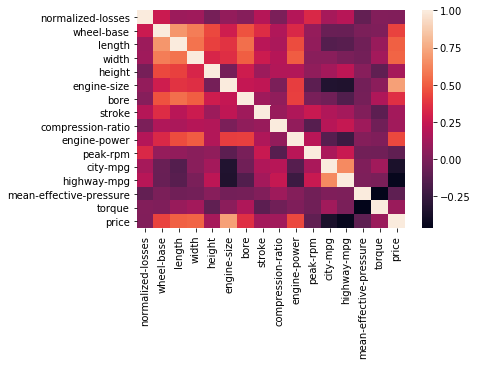

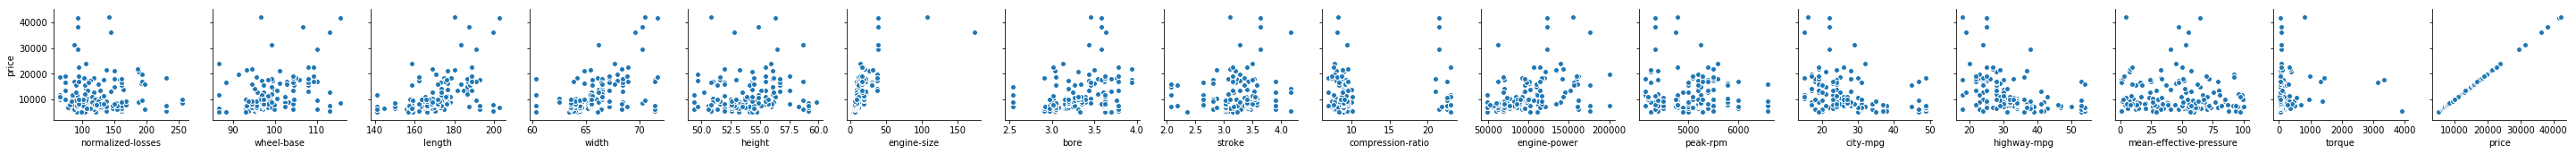

In [22]:
# Calculate the variables correlations
corr = auto_numeric.corr()
# Display the corrolations
sns.heatmap(corr)
# Display a pair plot
sns.pairplot(data=auto_numeric, y_vars='price', x_vars=auto_numeric.columns.values)
plt.show()

#### Answer
None of the variables seem good enough to predict price on their own. The best attribute might be width, however it looks like it is approximately as descriptive as engine-power. Engine size also looks like it might be a good indicator however a few outliers make it hard to tell from the graph. A number of the values look like they would be useless for making a prediction for a variety of reasons. Torque shows almost all of the cars being at the same value. Mean-effective-pressure, highway-mpg, city-mpg, stroke and peak-rpm all appear to be approximately uniformly distributed. Compression ratio is also almost definitely not helpful in describing the price as all of the data is centered at two values, both of which appear to be uniformly distributed. I think it would be reasonable to remove all of these values.

### ========== Question 2.2 --- [3 marks] ==========
We will now make a first attempt at building a Multivariate Linear Regression model using all numeric attributes. Initialise a `LinearRegression` model and predict the output by using 5-fold cross-validation and the `cross_val_predict` function.

In [42]:
# Set the target and training variables
x_data_multivariate = np.array(auto_numeric.copy().drop('price', axis=1))
y_data_multivariate = auto_numeric['price']
# Fit a linear regression
linear_model_multivariate = LinearRegression().fit(X=x_data_multivariate , y=y_data_multivariate)
# Predict output
y_pred_multivariate = cross_val_predict(linear_model_multivariate, X=x_data_multivariate , y=y_data_multivariate , cv=kf.split(auto_numeric))

### ========== Question 2.3 --- [2 marks] ==========
Display the Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and Correlation Coefficient (CC).

In [43]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=y_data_multivariate, y_pred=y_pred_multivariate)))
print('MAE:', mean_absolute_error(y_true=y_data_multivariate, y_pred=y_pred_multivariate))
print('Correlation Coefficient:', np.corrcoef(x=y_pred_multivariate, y=y_data_multivariate)[0][1])

RMSE: 4819.80464283
MAE: 3050.34459963
Correlation Coefficient: 0.742560270537


### ========== Question 2.4 --- [2 marks] ==========
 Comment on each metric display above in comparison to what you have obtained for the Simple Linear Regression model in Question 1.19.

#### Answer
The errors are much lower for the multivariate regression. It has a lot more data to use for the regression, and hence can create more informed predictions.

### ========== Question 2.5 --- [2 marks] ==========
Examine the histogram for the `engine-size` attribute. Choose a sensible value for the number of bins in the histogram. Label axes appropriately and include a title in your plot.

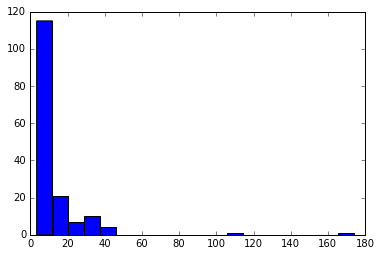

In [24]:
plt.hist(auto_numeric['engine-size'], bins=20)
plt.show()

### ========== Question 2.6 --- [2 marks] ==========
Is the distribution expected to cause a problem for regression? Explain your answer in 2-3 sentences.

#### Answer
The distribution shows that there are a lot more data points for cars with small engines than large engines. The data looks exponentially distributed, which can not be approximated well by a linear model.

### ========== Question 2.7 --- [3 marks] ==========
Transform this attribute using an appropriate simple technique from the lectures. Plot the histogram of the transformed attribute.

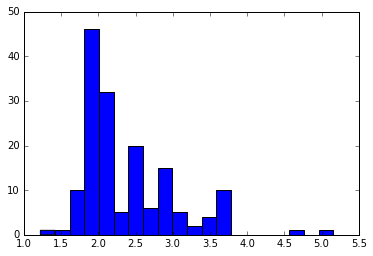

In [25]:
# Take the log of the engine size
log_engine_size = np.log(auto_numeric['engine-size'])
# Display the transformed attribute
plt.hist(log_engine_size, bins=20)
plt.show()

### ========== Question 2.8 --- [3 marks] ==========
Now re-build a Linear Regression model on the transformed dataset and report the R^2, RMSE, MAE and CC metrics.

In [45]:
transformed_auto_numeric = auto_numeric.copy()
transformed_auto_numeric['engine-size'] = np.log(transformed_auto_numeric['engine-size'])
transformed_y = transformed_auto_numeric['price']
transformed_x = transformed_auto_numeric.drop('price', axis=1)
transformed_linear_regression = LinearRegression().fit(X=transformed_x, y=transformed_y)
y_pred_transformed = cross_val_predict(transformed_linear_regression, X=transformed_x , y=transformed_y , cv=kf.split(auto_numeric))
# Calculate and display accuracy statistics
print('RMSE:', np.sqrt(mean_squared_error(y_true=transformed_y, y_pred=y_pred_transformed)))
print('MAE:', mean_absolute_error(y_true=transformed_y, y_pred=y_pred_transformed))
print('Correlation Coefficient:', np.corrcoef(x=transformed_y, y=y_pred_transformed)[0][1])

RMSE: 3745.91959756
MAE: 2668.36429567
Correlation Coefficient: 0.831675321657


### ========== Question 2.9 --- [3 marks] ==========
How has the performance of your model changed? Explain your answer in 1-2 sentences.

Doing a log transform seems to have helped the performance of the model. By transforming an exponential variable I'm not surprised that the linear model is able to make more accurate predictions.

# ========== Question 2.10 --- [2 marks] ==========
So far we have performed regression with numeric attributes. We will now attempt to integrate nominal (categorical) attributes into our regression model. 
Load the dataset `train_auto_full.csv` into a pandas DataFrame called `auto_full`. Display the number of samples and attributes in the dataset. Also, display the first 20 instances of the dataset. *Hint: Execute the cell below to change the default for `max_columns` display option in pandas.*

In [27]:
pd.set_option('max_columns', 30)

In [38]:
auto_full = pd.read_csv('datasets/train_auto_full.csv')
# Display the number of samples
print('Samples:', auto_full.shape[0])
print('Attributes:', auto_full.shape[1])
print(auto_full.head(20))

Samples: 159
Attributes: 27
    normalized-losses       make fuel-type aspiration  num-of-doors  \
0               164.0       audi       gas        std             4   
1               110.0       audi       gas        std             4   
2               158.0       audi       gas        std             4   
3               106.0       audi       gas      turbo             4   
4               192.0        bmw       gas        std             2   
5               194.0        bmw       gas        std             4   
6               188.0        bmw       gas        std             2   
7               150.0        bmw       gas        std             4   
8               121.0  chevrolet       gas        std             2   
9                98.0  chevrolet       gas        std             2   
10               93.0  chevrolet       gas        std             4   
11              231.0      dodge       gas        std             2   
12              118.0      dodge       gas       

### ========== Question 2.11 --- [3 marks] ==========
This dataset contains a mixture of numeric and nominal attributes. Name the variables that you think are categorical. Why can we not use the nominal attributes in their current form for the purposes of regression? 

#### Answer
The categorical attributes are: Make, fuel-type, aspiration, body-style, drive-wheels, engine-location, engine-type and fuel-system. Currently most of the nominal attributes are in the form of strings, which can not be used for the linear regression because a linear regression requires some sort of numerical representation to calculate.


### ========== Question 2.12 --- [5 marks] ==========
Now we want to convert the categorical variables by using [One-Hot-Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). Familiarise yourself with the class. One limitation with this module is that it can deal only with categorical attributes in integer format (remember that in our example we have attributes in string format). 

Copy the `auto_full` dataframe into a new dataframe `auto_full_edit` and transform the categorical variables by using [Label Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Then transform again the categorical variables by using One-Hot-Encoding. Make sure you don't transform the continuous variables. *Hint: make appropriate use of the `categorical_features` parameter in [`OneHotEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder).*

Store the transformed attributes into a numpy array `X_enc` and display its dimensionality.  


In [39]:
auto_full_edit = auto_full.copy().drop('price', axis=1)
le = LabelEncoder()
# Convert all of the categorical variables that are strings
auto_full_edit['make'] = le.fit_transform(auto_full_edit['make'])
auto_full_edit['fuel-type'] = le.fit_transform(auto_full_edit['fuel-type'])
auto_full_edit['aspiration'] = le.fit_transform(auto_full_edit['aspiration'])
auto_full_edit['body-style'] = le.fit_transform(auto_full_edit['body-style'])
auto_full_edit['drive-wheels'] = le.fit_transform(auto_full_edit['drive-wheels'])
auto_full_edit['engine-location'] = le.fit_transform(auto_full_edit['engine-location'])
auto_full_edit['engine-type'] = le.fit_transform(auto_full_edit['engine-type'])
auto_full_edit['fuel-system'] = le.fit_transform(auto_full_edit['fuel-system'])
enc = OneHotEncoder(categorical_features=[1, 2, 3, 5, 6, 7, 12, 15])
X_enc = enc.fit_transform(auto_full_edit)
print(X_enc.shape)

(159, 60)


### ========== Question 2.13 --- [2 marks] ==========
By using the transformed data train a multivariate linear regression model and by using 5-fold cross-validation report the R^2, RMSE, MAE and CC metrics.

In [44]:
enc_y = auto_full['price']
transformed_linear_regression = LinearRegression().fit(X=X_enc, y=enc_y)
y_pred_enc = cross_val_predict(transformed_linear_regression, X=X_enc , y=enc_y , cv=kf.split(auto_numeric))
# Calculate and display accuracy statistics
print('Coefficient of Determination:', r2_score(y_true=enc_y, y_pred=y_pred_enc))
print('RMSE:', np.sqrt(mean_squared_error(y_true=enc_y, y_pred=y_pred_enc)))
print('MAE:', mean_absolute_error(y_true=enc_y, y_pred=y_pred_enc))
print('Correlation Coefficient:', np.corrcoef(x=enc_y, y=y_pred_enc))

Coefficient of Determination: 0.863501374744
RMSE: 2484.10710158
MAE: 1752.65388541
Correlation Coefficient: [[ 1.          0.93218178]
 [ 0.93218178  1.        ]]


### ========== Question 2.14 --- [4 marks] ==========
How does this more complex model perform with respect to your best performing model from either question 2.3 or 2.8? List one advantage and one disadvantage of using the more complex model.

The more complex model performs significantly better than any of the previous models. The improved accuracy of the complex model is an advantage. Disadvantages include the fact that it is more computationally intensive and requires more human intervention to build (eg. choosing and replacing categorical variables). Another potential disadvantage is that a complex model is much more likely to overfit to data.

### ========== Question 2.15 --- [4 marks] ==========
Finally, experiment with tree-based regressors (e.g. [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) and report 5-fold cross-validation scores for R^2, RMSE, MAE and CC. Has your performance improved? Explain your answer in 1-2 sentences.

In [46]:
random_forest_x = X_enc.copy()
random_forest_y = auto_full['price']
random_forest_regressor = RandomForestRegressor()
y_pred_rf = cross_val_predict(random_forest_regressor, X=random_forest_x , y=random_forest_y, cv=kf.split(auto_numeric))
# Calculate and display accuracy statistics
print('Coefficient of Determination:', r2_score(y_true=random_forest_y, y_pred=y_pred_rf))
print('RMSE:', np.sqrt(mean_squared_error(y_true=random_forest_y, y_pred=y_pred_rf)))
print('MAE:', mean_absolute_error(y_true=random_forest_y, y_pred=y_pred_rf))
print('Correlation Coefficient:', np.corrcoef(x=random_forest_y, y=y_pred_rf))

Coefficient of Determination: 0.826515079576
RMSE: 2800.50945527
MAE: 1916.17735849
Correlation Coefficient: [[ 1.          0.91321279]
 [ 0.91321279  1.        ]]


#### Answer
A random forest regressor does not improve performance over the complex model. 